## EA run comparisons 2010

Read all experiment data:

In [1]:
import os
import pandas as pd
import glob
import re
import numpy as np

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

#experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp"]
# experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp"]

# BO
#experiment_directories = ["500iters3years128units_BO2", "500iters3years128units_BO3", "500iters3years128units_BO4", "500iters3years128units_BO5", "500iters3years128units_BO1"]
# Island 18
#experiment_directories = ["500iters3years128units_Island18LS_1", "500iters3years128units_Island18LS_3", "500iters3years128units_Island18LS_4", "500iters3years128units_Island18LS_5", "500iters3years128units_Island18LS_6"]
#                           "500iters3years128units_Island18LS_2", # TODO: was problematic, too few global iters 
#                             "500iters3years128units_Island18LS100_7"] # TODO: 100 ls runs
# Island 5
#experiment_directories = ["500iters3years128units_Island5_1", "500iters3years128units_Island5_3",  "500iters3years128units_Island5_5", "500iters3years128units_Island5_2", "500iters3years128units_Island5_4"]
# RS
experiment_directories = ["500iters3years128units_RS3", "500iters3years128units_RS2", "500iters3years128units_RS1", "500iters3years128units_RS4", "500iters3years128units_RS5"]
# Island almost 4000 global
#experiment_directories = ["500iters3years128units_Island18_4000+global"]
# Island 400 global + 1000 local
#experiment_directories = ["500iters3years128units_Island18LS_1"]

    
run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2", "VSC", "EC2"] # "EC@"

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]        
#         print("df.shape", df.shape)
        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()        

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models/NarxModelSearch/runs/500iters3years128units_RS1/'

Best MAPE% and IOA%:

In [ ]:
df.sort_values(by=['holdoutMse'], ascending=True).head(5)

In [ ]:
df.sort_values(by=['cvMseMean'], ascending=True).head(5)

In [ ]:
df.sort_values(by=['holdoutIoa'], ascending=False).head(5)

In [ ]:
df.sort_values(by=['holdoutSmape'], ascending=True).head(10)

First n iterations:

In [ ]:
show_iters = 500

In [ ]:
store_best_model_line = True # Store minimizingMaximizing array(s) to CSV
if store_best_model_line:    
    df_best_model = pd.DataFrame()
    df_best_model["x"] = range(0, 500)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
#     "cvSmapeMeanAccuracy", 
#    "holdoutMse",
     "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [8, 6]
remove_outliers = False
outlier_std = 3
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)    
    return np.array(minsArray)
    
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


for current_experiment in experiment_directories:
    
    legends = []
    for variable in variables:    
       
        df2 = df.loc[df["experiment"] == current_experiment]        
#         df2 = df2.loc[df2["optimizer"] != "ls"]            
        df2 = df2.drop_duplicates().head(show_iters)
        df2.sort_index(inplace=True)
    
        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]
    
        dict_points = {}        
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)            
            i += 1
    
        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values 
        
        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel("100 - SMAPE%")
        ax.set_xlabel('# Fitness Evaluations')
       
#         z2 = np.polyfit(x, y, 2) 
#         trendpoly2d = np.poly1d(z2)
#         ax.plot(x, trendpoly2d(x) , 'r--')
#         legends.append("trend 2 degree polynomial")
        
#         z12 = np.polyfit(x, y, 12) 
#         trendpoly12d = np.poly1d(z12)
#         ax.plot(x, trendpoly12d(x) , 'c--')
#         legends.append("trend 12 degree polynomial")

        # Scatter plot all data points based on method    
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax.plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
#             legends.append(optimizer)
            i += 1
        legends = legends + ["Random (uniform) search (Rand)", "Differential Evolution (DE)", "Particle Swarm Optimization (PSO)", "Genetic Algorithm (GA)", "Local Search (LS)"]

        # Linear regression trend
        z = np.polyfit(x, y, 1) 
        trendpoly1d = np.poly1d(z)
#         print("trendpoly1d: ", trendpoly1d)
        ax.plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend: {:.3f}*x + {:.3f}".format(z[0], z[1]))        
       
        best_method = df2["optimizer"].loc[df2[variable].idxmin()].upper()
#         ax.set_title('Island Transpeciation - PM10 test accuracy (median: {:.2f}% +/- {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
#                      .format(df2[variable].median(), df2[variable].mad(), df2[variable].min(), df2[variable].max()))
        ax.set_title('Island Transpeciation - $O_3$ test 2010 (median: {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
             .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))

        best_model = getMinimizingMaximizingArray(df2[variable].values, minimizing)
        #best_model = getMinimizingMaximizingArray(df2[variable].values, True)
        ax.plot(x, best_model, "b-");
#         legends.append("minimizing " + variable)
        legends.append("Best model")
        
        if store_best_model_line: # Store minimizingMaximizing array(s) to CSV
            if best_model.shape[0] < 500:
                best_model2 = np.append(best_model, np.array([best_model.max()] * (500 - best_model.shape[0])))
                best_model = best_model2
            df_best_model[current_experiment] = best_model

        ax.legend(legends)
        
        ax.grid(True)                         
        fig.savefig("{}Test.svg".format(current_experiment))
        fig.savefig("{}Test.png".format(current_experiment))
#         break
#     break

if store_best_model_line:
    df_best_model.to_csv()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
    "cvSmapeMeanAccuracy", 
#     "holdoutMse",
#     "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [8, 6]
remove_outliers = False
outlier_std = 3
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)    
    return np.array(minsArray)
    
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:
    
    legends = []
    for variable in variables:    
       
        df2 = df.loc[df["experiment"] == current_experiment]
#         df2 = df2.loc[df2["optimizer"] != "ls"]
        
        df2 = df2.drop_duplicates().head(show_iters)
        df2.sort_index(inplace=True)
    
        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]
    
        dict_points = {}        
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)            
            i += 1
    
        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values 
        
        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel("100 - SMAPE%")
        ax.set_xlabel('# Fitness Evaluations')
       
#         z2 = np.polyfit(x, y, 2) 
#         trendpoly2d = np.poly1d(z2)
#         ax.plot(x, trendpoly2d(x) , 'r--')
#         legends.append("trend 2 degree polynomial")
        
#         z12 = np.polyfit(x, y, 12) 
#         trendpoly12d = np.poly1d(z12)
#         ax.plot(x, trendpoly12d(x) , 'c--')
#         legends.append("trend 12 degree polynomial")

        # Scatter plot all data points based on method    
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax.plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
#             legends.append(optimizer)
            i += 1
        legends = legends + ["Bayesian Optimization (BO)", "Random (uniform) search (Rand)", "Differential Evolution (DE)", "Particle Swarm Optimization (PSO)", "Genetic Algorithm (GA)", "Local Search (LS)"]

        # Linear regression trend
        z = np.polyfit(x, y, 1) 
        trendpoly1d = np.poly1d(z)
#         print("trendpoly1d: ", trendpoly1d)
        ax.plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend: {:.3f}*x + {:.3f}".format(z[0], z[1]))        
       
        best_method = df2["optimizer"].loc[df2[variable].idxmin()].upper()
#         ax.set_title('Island Transpeciation - PM10 test accuracy (median: {:.2f}% +/- {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
#                      .format(df2[variable].median(), df2[variable].mad(), df2[variable].min(), df2[variable].max()))
        ax.set_title('Island Transpeciation - $O_3$ train CV 2000-2009 (median: {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
             .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))

        ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
#         legends.append("minimizing " + variable)
        legends.append("Best model")

        ax.legend(legends)
        
        ax.grid(True)                         
        fig.savefig("{}Train.svg".format(current_experiment))    
        fig.savefig("{}Train.png".format(current_experiment))
#         break
#     break

In [ ]:
bo_mean = df_best_model[['500iters3years128units_BO2',
       '500iters3years128units_BO3', '500iters3years128units_BO4',
       '500iters3years128units_BO5', '500iters3years128units_BO1']].mean(axis=1)
island_18_mean = df_best_model[['500iters3years128units_Island18LS_1',
       '500iters3years128units_Island18LS_3',
       '500iters3years128units_Island18LS_4',
       '500iters3years128units_Island18LS_5',
       '500iters3years128units_Island18LS_6']].mean(axis=1)
island_5_mean = df_best_model[['500iters3years128units_Island5_1', '500iters3years128units_Island5_3',
       '500iters3years128units_Island5_5', '500iters3years128units_Island5_2',
       '500iters3years128units_Island5_4']].mean(axis=1)
rs_mean = df_best_model[['500iters3years128units_RS3', '500iters3years128units_RS2',
       '500iters3years128units_RS1', '500iters3years128units_RS4',
       '500iters3years128units_RS5']].mean(axis=1)

bo_median = df_best_model[['500iters3years128units_BO2',
       '500iters3years128units_BO3', '500iters3years128units_BO4',
       '500iters3years128units_BO5', '500iters3years128units_BO1']].median(axis=1)
island_18_median = df_best_model[['500iters3years128units_Island18LS_1',
       '500iters3years128units_Island18LS_3',
       '500iters3years128units_Island18LS_4',
       '500iters3years128units_Island18LS_5',
       '500iters3years128units_Island18LS_6']].median(axis=1)
island_5_median = df_best_model[['500iters3years128units_Island5_1', '500iters3years128units_Island5_3',
       '500iters3years128units_Island5_5', '500iters3years128units_Island5_2',
       '500iters3years128units_Island5_4']].median(axis=1)
rs_median = df_best_model[['500iters3years128units_RS3', '500iters3years128units_RS2',
       '500iters3years128units_RS1', '500iters3years128units_RS4',
       '500iters3years128units_RS5']].median(axis=1)

bo_max = df_best_model[['500iters3years128units_BO2',
       '500iters3years128units_BO3', '500iters3years128units_BO4',
       '500iters3years128units_BO5', '500iters3years128units_BO1']].max(axis=1)
island_18_max = df_best_model[['500iters3years128units_Island18LS_1',
       '500iters3years128units_Island18LS_3',
       '500iters3years128units_Island18LS_4',
       '500iters3years128units_Island18LS_5',
       '500iters3years128units_Island18LS_6']].max(axis=1)
island_5_max = df_best_model[['500iters3years128units_Island5_1', '500iters3years128units_Island5_3',
       '500iters3years128units_Island5_5', '500iters3years128units_Island5_2',
       '500iters3years128units_Island5_4']].max(axis=1)
rs_max = df_best_model[['500iters3years128units_RS3', '500iters3years128units_RS2',
       '500iters3years128units_RS1', '500iters3years128units_RS4',
       '500iters3years128units_RS5']].max(axis=1)

In [ ]:
df_best_model["B_O_mean"] = bo_mean
df_best_model["isl_and18_mean"] = island_18_mean
df_best_model["isl_and5_mean"] = island_5_mean
df_best_model["R_S_mean"] = rs_mean

df_best_model["B_O_median"] = bo_median
df_best_model["isl_and18_median"] = island_18_median
df_best_model["isl_and5_median"] = island_5_median
df_best_model["R_S_median"] = rs_median

df_best_model["B_O_max"] = bo_max
df_best_model["isl_and18_max"] = island_18_max
df_best_model["isl_and5_max"] = island_5_max
df_best_model["R_S_max"] = rs_max

In [ ]:
print(df_best_model["B_O_mean"].median())
print(df_best_model["isl_and18_mean"].median())
print(df_best_model["R_S_mean"].median())
print(df_best_model["isl_and5_mean"].median())
print(df_best_model["isl_and18_mean"].max())
print(df_best_model["isl_and18_max"].max())
print(df_best_model["isl_and18_median"].max())
print(df_best_model["isl_and5_mean"].max())
print(df_best_model["isl_and5_max"].max())
print(df_best_model["isl_and5_median"].max())

In [ ]:
import re
figure_size = (18,12)
fig, ax = plt.subplots(1, 4, figsize=figure_size)

metric_type = "median" # max, mean

ax[0].set_ylabel("100 - SMAPE%")
titles = ["Bayesian Optimization (Best: {}%)".format(round(df_best_model["B_O_max"].max(), 3), round(df_best_model["B_O_median"].mad(), 2)) , 
          "18 islands + LS (Best: {}%)".format(round(df_best_model["isl_and18_max"].max(), 3), round(df_best_model["isl_and18_median"].mad(), 2)) , 
          "5 islands (Best: {}%)".format(round(df_best_model["isl_and5_max"].max(), 3), round(df_best_model["isl_and5_median"].mad(), 2)) , 
          "Random Search (Best: {}%)".format(round(df_best_model["R_S_max"].max(), 3), round(df_best_model["R_S_median"].mad(), 2))
         ]
for i in range(0, ax.size):
    ax[i].set_xlabel('# Fitness Evaluations')
    ax[i].grid(True)   
    ax[i].set_ylim([0, 100])
    ax[i].set_xlim([0, 510])
    ax[i].set_title(titles[i])

alpha_value = 0.4

for column in df_best_model.columns:
    if column != "x":
        # TODO: change color per type
        # TODO: trendline
        line_type = "b-"
        
        if re.compile('B_O_{}'.format(metric_type)).search(column):
            line_type = "k-"
            ax[0].plot(df_best_model["x"], df_best_model[column], line_type)        
            ax[0].legend(["BO ({}% +/- {}%)".format(round(df_best_model["B_O_median"].median(), 3), round(df_best_model["B_O_median"].mad(), 3)) ])

        if re.compile('isl_and18_{}'.format(metric_type)).search(column):
            line_type = "k-"
            ax[1].plot(df_best_model["x"], df_best_model[column], line_type)
            ax[1].legend(["18 islands ({}% +/- {}%)".format(round(df_best_model["isl_and18_median"].median(), 3), round(df_best_model["isl_and18_median"].mad(), 3)) ])                
        
        if re.compile('isl_and5_{}'.format(metric_type)).search(column):
            line_type = "k-"
            ax[2].plot(df_best_model["x"], df_best_model[column], line_type)
            ax[2].legend(["5 islands ({}% +/- {}%)".format(round(df_best_model["isl_and5_median"].median(), 3), round(df_best_model["isl_and5_median"].mad(), 3)) ])
            
        if re.compile('R_S_{}'.format(metric_type)).search(column):
            line_type = "k-"
            ax[3].plot(df_best_model["x"], df_best_model[column], line_type)
            ax[3].legend(["RS ({}% +/- {}%)".format(round(df_best_model["R_S_median"].median(), 3), round(df_best_model["R_S_median"].mad(), 3)) ])    

# Plot max points            
for column in df_best_model.columns:
    if column != "x":
        # TODO: change color per type
        # TODO: trendline
        line_type = "b-"
        
        if re.compile('B_O_max'.format(metric_type)).search(column):
            line_type = "go"
            ax[0].plot(df_best_model["x"].max(), df_best_model[column].max(), line_type)

        if re.compile('isl_and18_max'.format(metric_type)).search(column):
            line_type = "bo"
            ax[1].plot(df_best_model["x"].max(), df_best_model[column].max(), line_type)
        
        if re.compile('isl_and5_max'.format(metric_type)).search(column):
            line_type = "bo"
            ax[2].plot(df_best_model["x"].max(), df_best_model[column].max(), line_type)
            
        if re.compile('R_S_max'.format(metric_type)).search(column):
            line_type = "ro"
            ax[3].plot(df_best_model["x"].max(), df_best_model[column].max(), line_type)
                        
            
for column in df_best_model.columns:
    if column != "x":
        # TODO: change color per type
        # TODO: trendline
        line_type = "b-"
        
        if re.compile('BO').search(column):
            line_type = "g--"
            ax[0].plot(df_best_model["x"], df_best_model[column], line_type, alpha=alpha_value)
        
        if re.compile('Island18').search(column):
            line_type = "b--"
            ax[1].plot(df_best_model["x"], df_best_model[column], line_type, alpha=alpha_value)
            
        if re.compile('Island5').search(column):
            line_type = "b--"
            ax[2].plot(df_best_model["x"], df_best_model[column], line_type, alpha=alpha_value)
            
        if re.compile('RS').search(column):
            line_type = "r--"
            ax[3].plot(df_best_model["x"], df_best_model[column], line_type, alpha=alpha_value)
            
            
            
            

In [ ]:
import re
figure_size = (18,12)
fig, ax = plt.subplots(1, 4, figsize=figure_size)

metric_type = "median" # max, mean

ax[0].set_ylabel("100 - SMAPE%")
titles = ["Bayesian Optimization (Best: {}%)".format(round(df_best_model["B_O_max"].max(), 3), round(df_best_model["B_O_median"].mad(), 2)) , 
          "18 islands + LS (Best: {}%)".format(round(df_best_model["isl_and18_max"].max(), 3), round(df_best_model["isl_and18_median"].mad(), 2)) , 
          "5 islands (Best: {}%)".format(round(df_best_model["isl_and5_max"].max(), 3), round(df_best_model["isl_and5_median"].mad(), 2)) , 
          "Random Search (Best: {}%)".format(round(df_best_model["R_S_max"].max(), 3), round(df_best_model["R_S_median"].mad(), 2))
         ]
for i in range(0, ax.size):
    ax[i].set_xlabel('# Fitness Evaluations')
    ax[i].grid(True)   
    ax[i].set_ylim([76, 76.35])
    ax[i].set_xlim([0, 510])
    ax[i].set_title(titles[i])

alpha_value = 0.4

for column in df_best_model.columns:
    if column != "x":
        # TODO: change color per type
        # TODO: trendline
        line_type = "b-"
        
        if re.compile('B_O_{}'.format(metric_type)).search(column):
            line_type = "k-"
            ax[0].plot(df_best_model["x"], df_best_model[column], line_type)        
            ax[0].legend(["BO ({}% +/- {}%)".format(round(df_best_model["B_O_median"].median(), 3), round(df_best_model["B_O_median"].mad(), 3)) ])

        if re.compile('isl_and18_{}'.format(metric_type)).search(column):
            line_type = "k-"
            ax[1].plot(df_best_model["x"], df_best_model[column], line_type)
            ax[1].legend(["18 islands ({}% +/- {}%)".format(round(df_best_model["isl_and18_median"].median(), 3), round(df_best_model["isl_and18_median"].mad(), 3)) ])                
        
        if re.compile('isl_and5_{}'.format(metric_type)).search(column):
            line_type = "k-"
            ax[2].plot(df_best_model["x"], df_best_model[column], line_type)
            ax[2].legend(["5 islands ({}% +/- {}%)".format(round(df_best_model["isl_and5_median"].median(), 3), round(df_best_model["isl_and5_median"].mad(), 3)) ])
            
        if re.compile('R_S_{}'.format(metric_type)).search(column):
            line_type = "k-"
            ax[3].plot(df_best_model["x"], df_best_model[column], line_type)
            ax[3].legend(["RS ({}% +/- {}%)".format(round(df_best_model["R_S_median"].median(), 3), round(df_best_model["R_S_median"].mad(), 3)) ])    

# Plot max points            
for column in df_best_model.columns:
    if column != "x":
        # TODO: change color per type
        # TODO: trendline
        line_type = "b-"
        
        if re.compile('B_O_max'.format(metric_type)).search(column):
            line_type = "go"
            ax[0].plot(df_best_model["x"].max(), df_best_model[column].max(), line_type)

        if re.compile('isl_and18_max'.format(metric_type)).search(column):
            line_type = "bo"
            ax[1].plot(df_best_model["x"].max(), df_best_model[column].max(), line_type)
        
        if re.compile('isl_and5_max'.format(metric_type)).search(column):
            line_type = "bo"
            ax[2].plot(df_best_model["x"].max(), df_best_model[column].max(), line_type)
            
        if re.compile('R_S_max'.format(metric_type)).search(column):
            line_type = "ro"
            ax[3].plot(df_best_model["x"].max(), df_best_model[column].max(), line_type)
                        
            
for column in df_best_model.columns:
    if column != "x":
        # TODO: change color per type
        # TODO: trendline
        line_type = "b-"
        
        if re.compile('BO').search(column):
            line_type = "g--"
            ax[0].plot(df_best_model["x"], df_best_model[column], line_type, alpha=alpha_value)
        
        if re.compile('Island18').search(column):
            line_type = "b--"
            ax[1].plot(df_best_model["x"], df_best_model[column], line_type, alpha=alpha_value)
            
        if re.compile('Island5').search(column):
            line_type = "b--"
            ax[2].plot(df_best_model["x"], df_best_model[column], line_type, alpha=alpha_value)
            
        if re.compile('RS').search(column):
            line_type = "r--"
            ax[3].plot(df_best_model["x"], df_best_model[column], line_type, alpha=alpha_value)
            
            
            
            

In [ ]:
import re
figure_size = (18,6)
fig, ax = plt.subplots(1, 1, figsize=figure_size)
ax.set_ylabel("100 - SMAPE%")
titles = ["Bayesian Optimization (Best: {}%)".format(round(df_best_model["B_O_max"].max(), 3), round(df_best_model["B_O_median"].mad(), 2)) , 
          "18 islands + LS (Best: {}%)".format(round(df_best_model["isl_and18_max"].max(), 3), round(df_best_model["isl_and18_median"].mad(), 2)) , 
          "5 islands (Best: {}%)".format(round(df_best_model["isl_and5_max"].max(), 3), round(df_best_model["isl_and5_median"].mad(), 2)) , 
          "Random Search (Best: {}%)".format(round(df_best_model["R_S_max"].max(), 3), round(df_best_model["R_S_median"].mad(), 2)) , 
         ]
ax.set_title("Optimization progress (5 samples): median +/- Mean Absolute Deviation (MAD)")

# for column in ['B_O_mean', 'isl_and18_mean', 'R_S_mean', 'isl_and5_mean']:
#     if column != "x":
#         if re.compile('B_O_mean').search(column):
#             line_type = "g-"
#             ax.plot(df_best_model["x"], df_best_model[column], line_type)        
#         if re.compile('isl_and18_mean').search(column):
#             line_type = "b-"
#             ax.plot(df_best_model["x"], df_best_model[column], line_type)
#         if re.compile('R_S_mean').search(column):
#             line_type = "r-"
#             ax.plot(df_best_model["x"], df_best_model[column], line_type)
#         if re.compile('isl_and5_mean').search(column):
#             line_type = "k-"
#             ax.plot(df_best_model["x"], df_best_model[column], line_type)

for column in ['B_O_median', 'isl_and18_median', 'R_S_median', 'isl_and5_median']:
    if column != "x":
        if re.compile('B_O_median').search(column):
            line_type = "g-"
            ax.plot(df_best_model["x"], df_best_model[column], line_type)        
        if re.compile('isl_and18_median').search(column):
            line_type = "b-"
            ax.plot(df_best_model["x"], df_best_model[column], line_type)
        if re.compile('isl_and5_median').search(column):
            line_type = "k-"
            ax.plot(df_best_model["x"], df_best_model[column], line_type)  
        if re.compile('R_S_median').search(column):
            line_type = "r-"
            ax.plot(df_best_model["x"], df_best_model[column], line_type)

                        
ax.set_xlabel('# Fitness Evaluations')
ax.grid(True)   
ax.set_ylim([0, 100])
ax.set_xlim([0, 510])
ax.legend(titles)

In [ ]:
import re
figure_size = (18,6)
fig, ax = plt.subplots(1, 1, figsize=figure_size)
ax.set_ylabel("100 - SMAPE%")
titles = ["Bayesian Optimization (BO) (median: {}% +/- {}%)".format(round(df_best_model["B_O_median"].median(), 3), round(df_best_model["B_O_median"].mad(), 3)) , 
          "18 islands + LS (median: {}% +/- {}%)".format(round(df_best_model["isl_and18_median"].median(), 3), round(df_best_model["isl_and18_median"].mad(), 3)) , 
          "5 islands (median: {}% +/- {}%)".format(round(df_best_model["isl_and5_median"].median(), 3), round(df_best_model["isl_and5_median"].mad(), 3)) , 
          "Random Search (RS) (median: {}% +/- {}%)".format(round(df_best_model["R_S_median"].median(), 3), round(df_best_model["R_S_median"].mad(), 3)) , 
         ]
ax.set_title("Optimization progress (5 samples): median +/- Mean Absolute Deviation (MAD)")

for column in ['B_O_median', 'isl_and18_median', 'R_S_median', 'isl_and5_median']:
    if column != "x":
        if re.compile('B_O_median').search(column):
            line_type = "g-"
            ax.plot(df_best_model["x"], df_best_model[column], line_type)        
        if re.compile('isl_and18_median').search(column):
            line_type = "b-"
            ax.plot(df_best_model["x"], df_best_model[column], line_type)
        if re.compile('isl_and5_median').search(column):
            line_type = "k-"
            ax.plot(df_best_model["x"], df_best_model[column], line_type)  
        if re.compile('R_S_median').search(column):
            line_type = "r-"
            ax.plot(df_best_model["x"], df_best_model[column], line_type)
     
                        
ax.set_xlabel('# Fitness Evaluations')
ax.grid(True)   
ax.set_ylim([76, 76.3])
ax.set_xlim([0, 510])
ax.legend(titles)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
#     "cvSmapeMeanAccuracy", 
#     "holdoutMse",
    "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [10, 8]
remove_outliers = False
outlier_std = 2
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)    
    return np.array(minsArray)
    
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:
    
    legends = []
    for variable in variables:    
       
        df2 = df.loc[df["experiment"] == current_experiment]
        
#         df2 = df2.loc[df2["optimizer"] != "ls"]
        
        df2 = df2.drop_duplicates()
        df2.sort_index(inplace=True)
    
        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]
    
        dict_points = {}        
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)            
            i += 1
    
        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values 
        
        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel(variable)
        ax.set_xlabel('# Fitness Evaluations')

        # Linear regression trend
        z = np.polyfit(x, y, 1) 
        trendpoly1d = np.poly1d(z)
#         print("trendpoly1d: ", trendpoly1d)
        ax.plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend " + variable + ": {:.3f}*x + {:.3f}".format(z[0], z[1]))
        
        z2 = np.polyfit(x, y, 2) 
        trendpoly2d = np.poly1d(z2)
        ax.plot(x, trendpoly2d(x) , 'r--')
        legends.append("trend 2 degree polynomial")
        
        z12 = np.polyfit(x, y, 12) 
        trendpoly12d = np.poly1d(z12)
        ax.plot(x, trendpoly12d(x) , 'c--')
        legends.append("trend 12 degree polynomial")
                
        # Scatter plot all data points based on method    
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax.plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
            legends.append(optimizer)
            i += 1

        ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
        legends.append("minimizing " + variable)
        
        ax.legend(legends)
        best_method = df2["optimizer"].loc[df2[variable].idxmin()]
        ax.set_title('{} (evals: {}, min: {:.2f}, max: {:.2f}, median: {:.2f} +/- {:.2f}, mean: {:.2f} +/- {:.2f}, best: {}) - Experiment: {}'
                     .format(variable, len(df2[variable]), df2[variable].min(), df2[variable].max(), df2[variable].median(), df2[variable].mad(), 
                             df2[variable].mean(), df2[variable].std(), best_method, current_experiment))
        ax.grid(True) 
    
#         break
#     break

## Worker execution times: Bar chart with error bars

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

def flatten(seq, container=None):
    if container is None:
        container = []
    for s in seq:
        try:
            iter(s)  # check if it's iterable
        except TypeError:
            container.append(s)
        else:
            flatten(s, container)
    return container

workers = df["worker"].unique()

means = []
samples = 0
outlier_std = 3
for current_worker in workers:
    experiment_means = []
    for current_experiment in experiment_directories:
        df_worker = df.loc[df["experiment"] == current_experiment]
        df_worker = df_worker.loc[df_worker["worker"] == current_worker]
        df_worker = df_worker.drop_duplicates()
        df_worker = df_worker.dropna()
        df_worker.sort_index(inplace=True)
        df_worker['datetimestamp'] = df_worker.index                
        df_worker = df_worker[~(np.abs(df_worker["datetimestamp"] - df_worker["datetimestamp"].mean()) > (outlier_std * df_worker["datetimestamp"].std()))]        
        diff = df_worker["datetimestamp"].diff().dropna()
        mean = diff.mean(skipna=True)
        if "P100" in current_worker or "4xV100" in current_worker:
            mean *= 4        
        if mean is not None and not math.isnan(mean):
            samples += diff.size
            experiment_means.append(mean / 60.0)
    means.append(experiment_means)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
workers = list(workers)
#fourV100 = workers.index('EC2/4xV100a')
#oneV100 = workers.index('EC2/1xV100')
#means[fourV100].append(means[oneV100][0])
#del means[oneV100]

all_data = means
labels = []
for x, y in zip(['GTX 970 & 1070Ti', 'Jetson TX2', 'V100s + cascadeLake'], [np.mean(x) for x in all_data]):
    labels.append("{}\n({:.2f} mins/model)".format(x, y))

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('GPU Workers')
    ax.set_ylabel('Time (minutes)')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels)
plt.savefig("rnnTrainingTimes.svg")
plt.savefig("rnnTrainingTimes.png")
plt.show()

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

def flatten(seq, container=None):
    if container is None:
        container = []
    for s in seq:
        try:
            iter(s)  # check if it's iterable
        except TypeError:
            container.append(s)
        else:
            flatten(s, container)
    return container

workers = df["worker"].unique()

means = []
samples = 0
outlier_std = 3

for current_worker in workers:
    experiment_means = []
    for current_experiment in experiment_directories:
        df_worker = df.loc[df["experiment"] == current_experiment]
        df_worker = df_worker.loc[df_worker["worker"] == current_worker]
        df_worker = df_worker.drop_duplicates()
        df_worker = df_worker.dropna()
        df_worker.sort_index(inplace=True)
        df_worker['datetimestamp'] = df_worker.index                
        df_worker = df_worker[~(np.abs(df_worker["datetimestamp"] - df_worker["datetimestamp"].mean()) > (outlier_std * df_worker["datetimestamp"].std()))]        
        diff = df_worker["datetimestamp"].diff().dropna()
        mean = diff.mean(skipna=True)
        if "P100" in current_worker or "4xV100" in current_worker:
            mean *= 4        
        if mean is not None and not math.isnan(mean):
            samples += diff.size
            experiment_means.append(mean / 60.0)
    means.append(experiment_means)

# Plot


figure_size = (6, 4)  # (16, 14)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
workers = list(workers)
#fourV100 = workers.index('EC2/4xV100a')
#oneV100 = workers.index('EC2/1xV100')
#means[fourV100].append(means[oneV100][0])
#del means[oneV100]

all_data = means
labels = []
for x, y in zip(['GTX 970 & 1070Ti', 'Jetson TX2', 'V100s + cascadeLake'], [np.mean(x) for x in all_data]):
    labels.append("{}\n≈{:.2f}\nmins/model".format(x, y))

axes.violinplot(all_data, showmeans=False, showmedians=True)
axes.set_title('Island DNN training times vs GPU ({} samples, 99.73% CI)'.format(samples))
axes.set_title('Training times vs GPU ({} samples, 99.73% CI)'.format(samples))
# axes[1].boxplot(all_data)
# axes[1].set_title('Box plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))

axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_xlabel('GPU Workers')
axes.set_ylabel('Time (minutes)')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))], xticklabels=labels)
plt.savefig("rnnTrainingTimes.svg")
plt.savefig("rnnTrainingTimes.png")
plt.show()

In [ ]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np


models_per_hour = []
models_per_hour_std = []
for gpu_worker in all_data:
    models_per_hour.append(np.mean(60.0 / np.array(gpu_worker)))
    models_per_hour_std.append(np.std(60.0 / np.array(gpu_worker)))
prices = [5281, (136 + 369) / 2.0, 6865, 352]
price_per_model_hour = np.array(prices) / np.array(models_per_hour)

price_per_model_hour_std = price_per_model_hour * (np.array(models_per_hour_std) / np.array(models_per_hour))
print("price_per_model_hour_std", price_per_model_hour_std)

gpu_workers = ['GTX 970 & 1070Ti', 'Jetson TX2']
price_per_model_hour = [x for y,x in sorted(zip(gpu_workers, price_per_model_hour))]
gpu_workers = [y for y,x in sorted(zip(gpu_workers, price_per_model_hour))]

price_per_model_hour_std = [26.98099847, 64.96931466, 495.39481663,  110.15980803]  # TODO: hardcoded

x = np.arange(4)
def millions(x, pos):
    return '{:.0f} €'.format(x)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(12, 4))
ax.xaxis.set_major_formatter(formatter)
plt.barh(x, price_per_model_hour, xerr=price_per_model_hour_std)
# plt.barh(x, price_per_model_hour)
ax.set_title('Cost per model-hour - RNN (4 layers) vs GPU ({} samples 99.73% CI)'.format(samples))
ax.set_ylabel('GPU Workers')
ax.set_xlabel('Price (€)')
plt.yticks(x, gpu_workers)
for i, v in enumerate(price_per_model_hour):
    ax.text(v + 4, i + 0.1, str(round(v, 1)) + "€ +/- {:.1f}€ per model-hour".format(price_per_model_hour_std[i]) , color='blue', fontweight='bold')
plt.show()

## All models structure

In [2]:
import os
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp"]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]
        
        full_parameters = []
        for params in df["full_parameters"].tolist():
#             print(params)
            full_parameters.append([float(z) for z in params.replace('[', '').replace(']', '').split(", ")])

        df["full_parameters"] = full_parameters        
        a = ["batch_size",
            "epoch_size",
            "optimizer",
            "units1",
            "units2",
            "units3",
            "dropout1",
            "dropout2",
            "dropout3",
            "recurrent_dropout1",
            "recurrent_dropout2",
            "recurrent_dropout3",
            "gaussian_noise_std1",
            "gaussian_noise_std2",
            "gaussian_noise_std3",
            "batch_normalization1",
            "batch_normalization2",
            "batch_normalization3",
            "gaussian_noise1",
            "gaussian_noise2",
            "gaussian_noise3",
            "layer_type1",
            "layer_type2",
            "layer_type3",
            "layer_initializer1",
            "layer_initializer2",
            "layer_initializer3"]
            
        c = 0
        for asdf in zip(*full_parameters):
            df[a[c]] = asdf
            c +=1
        
        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()        

df.shape: (139, 43)


,iteration,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,...,batch_normalization3,gaussian_noise1,gaussian_noise2,gaussian_noise3,layer_type1,layer_type2,layer_type3,layer_initializer1,layer_initializer2,layer_initializer3
datetime,,,,,,,,,,,,,,,,,,,,,
1595801161,84,3,155.531346,34.402721,19.389127,2.122808,13.073486,20.375327,34.099449,170.916043,...,0.879346,0.946241,0.261471,0.154837,1.61415,1.152794,0.788593,6.403163,6.595599,1.384213
1595803661,85,3,144.976830,27.300939,18.851981,1.616283,11.885208,19.073028,29.930110,141.258172,...,0.879346,0.946241,0.261471,0.154837,1.61415,1.152794,0.788593,6.403163,6.595599,1.384213
1595804305,86,3,158.694764,36.201600,18.930933,1.409321,13.021968,20.713631,31.586162,169.571639,...,0.879346,0.946241,0.261471,0.154837,1.61415,1.152794,0.788593,6.403163,6.595599,1.384213
1595804981,87,3,151.011515,35.332579,18.672710,1.922259,11.863920,19.099891,25.125377,140.752603,...,0.879346,0.946241,0.261471,0.154837,1.61415,1.152794,0.788593,6.403163,6.595599,1.384213
1595805623,88,3,156.261442,31.794574,18.762872,1.517785,12.726641,20.239328,27.370841,161.967402,...,0.879346,0.946241,0.261471,0.154837,1.61415,1.152794,0.788593,6.403163,6.595599,1.384213


In [3]:
import os
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp"]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]
        
        
        full_parameters = []
        for params in df["full_parameters"].tolist():
#             print(params)
            full_parameters.append([float(z) for z in params.replace('[', '').replace(']', '').split(", ")])

        df["full_parameters"] = full_parameters        
        a = ["batch_size",
            "epoch_size",
            "optimizer",
            "units1",
            "units2",
            "units3",
            "dropout1",
            "dropout2",
            "dropout3",
            "recurrent_dropout1",
            "recurrent_dropout2",
            "recurrent_dropout3",
            "gaussian_noise_std1",
            "gaussian_noise_std2",
            "gaussian_noise_std3",
            "batch_normalization1",
            "batch_normalization2",
            "batch_normalization3",
            "gaussian_noise1",
            "gaussian_noise2",
            "gaussian_noise3",
            "layer_type1",
            "layer_type2",
            "layer_type3",
            "layer_initializer1",
            "layer_initializer2",
            "layer_initializer3"]
            
        c = 0
        for asdf in zip(*full_parameters):
            df[a[c]] = asdf
            c +=1
        
        df = df.nlargest(1, 'holdoutSmapeAccuracy') # TODO: top 1 champion models

        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

# df = df.nlargest(20, 'holdoutSmapeAccuracy') # TODO: get top 10 champion models
print("df.shape:", df.shape)
df.tail()        

df.shape: (6, 43)


,iteration,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,...,batch_normalization3,gaussian_noise1,gaussian_noise2,gaussian_noise3,layer_type1,layer_type2,layer_type3,layer_initializer1,layer_initializer2,layer_initializer3
datetime,,,,,,,,,,,,,,,,,,,,,
1595629799,22,4,147.287074,36.910473,18.714599,2.005162,12.047312,19.308558,29.177397,145.137718,...,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,6.000000,4.000000,9.000000
1595630568,23,15,160.099103,35.747646,18.974866,1.506413,12.377345,20.052759,27.442259,153.198676,...,0.480914,0.841753,0.125814,0.482569,1.000381,0.655148,0.638765,2.280170,3.204168,6.367896
1595653164,30,7,138.627162,29.629418,18.589618,1.795089,11.415569,18.675988,28.902311,130.315206,...,0.266285,0.149988,0.028144,0.479218,0.364746,0.652132,0.654174,6.127038,6.875080,6.872721
1595655496,32,16,156.394471,36.686808,18.606091,1.639948,11.736846,18.971786,25.949817,137.753560,...,0.575170,0.457931,0.543610,0.513798,0.263415,1.715820,1.000168,2.537945,1.142728,7.744631
1595750956,37,3,158.288677,44.970693,19.197268,3.305544,11.366298,17.966803,23.670138,129.192736,...,0.879346,0.946241,0.261471,0.154837,1.614150,1.152794,0.788593,6.403163,6.595599,1.384213


In [4]:
units1 = []
units2 = []
units3 = []
layer_type1 = []
layer_type2 = []
layer_type3 = []

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp"]

# selected_experiments = [experiment_directories[0, 1, 2, 3, 4]]

# df_models = df.loc[df["experiment"] == experiment_directories[0]]  # For 1 experiment
df_models = df[df['experiment'].isin(experiment_directories[0:1])]
# df_models = df[df['experiment'].isin(experiment_directories[4:7])]  # For many experiments
df_models = df[df['experiment'].isin(experiment_directories)]  # all experiments
first_iterations = 400
for element in df_models["full_parameters"].head(first_iterations):  # For the first EA iterations
# for element in df_models["full_parameters"]:    
    units1.append(element[3])
    units2.append(element[4])
    units3.append(element[5])
    layer_type1.append(np.around(element[21], decimals=0).astype(int))
    layer_type2.append(np.around(element[22], decimals=0).astype(int))
    layer_type3.append(np.around(element[23], decimals=0).astype(int))
#     layer_type1.append(element[15])
#     layer_type2.append(element[16])
#     layer_type3.append(element[17])
units = [units1, units2, units3]    
layer_types = [layer_type1, layer_type2, layer_type3]

## Best:

In [5]:
best_df_model = df_models.loc[df_models["holdoutSmapeAccuracy"] == df_models["holdoutSmapeAccuracy"].max()]
best_pm10_params = best_df_model["full_parameters"]
layer_types_list = ["LSTM", "BiLSTM", "GRU", "BiGRU", "RNN", "BiRNN"]
for element in best_pm10_params:
    print("\nBest model(units):")
    print(np.around(element[3], decimals=0).astype(int), end=", ")
    print(np.around(element[4], decimals=0).astype(int), end=", ")
    print(np.around(element[5], decimals=0).astype(int), end="")
    print("\nBest model(layers):")
    print(layer_types_list[np.around(element[21], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[22], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[23], decimals=0).astype(int)], end=", ")
best_df_model
list(best_pm10_params)
np.around(list(best_pm10_params), decimals=0).astype(int)
print("\nMax holdoutSmapeAccuracy: {:.2f}%".format(df_models["holdoutSmapeAccuracy"].max()))
print("\nMin holdoutMse: {:.2f}".format(df_models["holdoutMse"].min()))
print("\nMin cvMseMean: {:.2f}".format(df_models["cvMseMean"].min()))


Best model(units):
96, 204, 129
Best model(layers):
GRU, BiLSTM, BiLSTM, 
Max holdoutSmapeAccuracy: 82.03%

Min holdoutMse: 126.14

Min cvMseMean: 134.11


## Worst:

In [6]:
worst_df_model = df_models.loc[df_models["holdoutSmapeAccuracy"] == df_models["holdoutSmapeAccuracy"].min()]
worst_pm10_params = worst_df_model["full_parameters"]
layer_types_list = ["LSTM", "BiLSTM", "GRU", "BiGRU", "RNN", "BiRNN"]
for element in worst_pm10_params:
    print("\nBest model(units):")
    print(np.around(element[3], decimals=0).astype(int), end=", ")
    print(np.around(element[4], decimals=0).astype(int), end=", ")
    print(np.around(element[5], decimals=0).astype(int), end="")
    print("\nBest model(layers):")
    print(layer_types_list[np.around(element[21], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[22], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[23], decimals=0).astype(int)], end=", ")

worst_df_model    
list(worst_pm10_params)
np.around(list(worst_pm10_params), decimals=0).astype(int)
print("\nMax holdoutSmapeAccuracy: {:.2f}%".format(df_models["holdoutSmapeAccuracy"].min()))
print("\nMax holdoutMse: {:.2f}".format(df_models["holdoutMse"].max()))
print("\nMax cvMseMean: {:.2f}".format(df_models["cvMseMean"].max()))


Best model(units):
260, 298, 240
Best model(layers):
BiLSTM, BiLSTM, BiLSTM, 
Max holdoutSmapeAccuracy: 79.95%

Max holdoutMse: 153.20

Max cvMseMean: 160.10


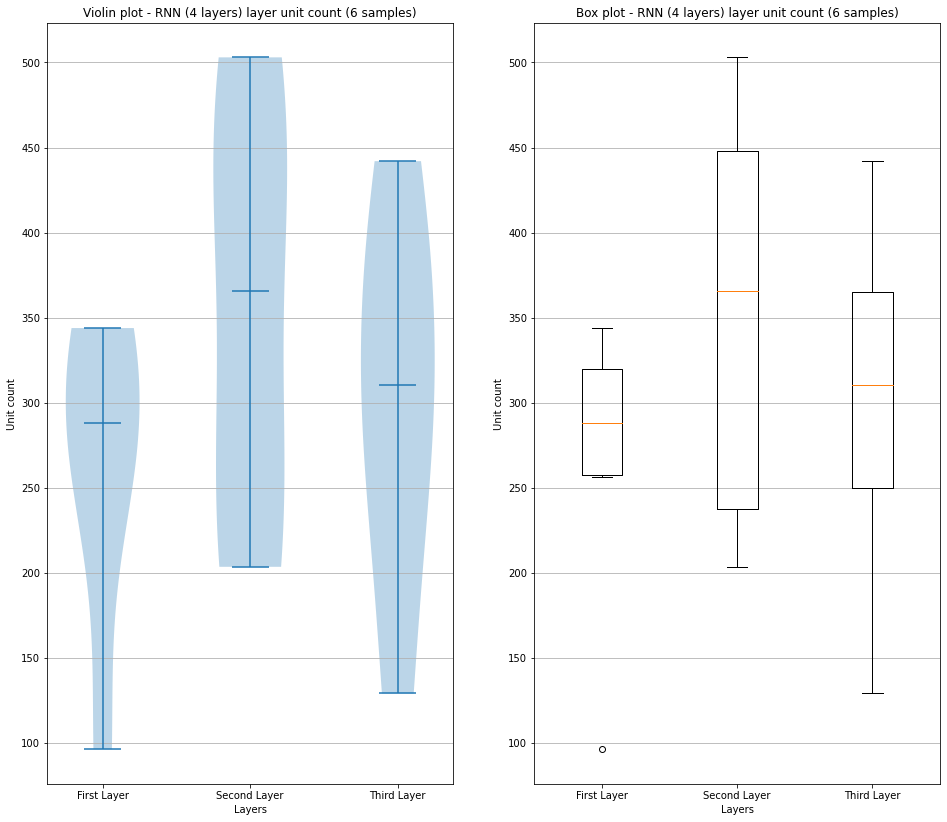

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
samples = len(units[0])
labels = ["First Layer", "Second Layer", "Third Layer"]
all_data = units

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) layer unit count ({} samples)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) layer unit count ({} samples)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('Layers')
    ax.set_ylabel('Unit count')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels)
plt.show()

<ipython-input-8-f9a57ca30439>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],


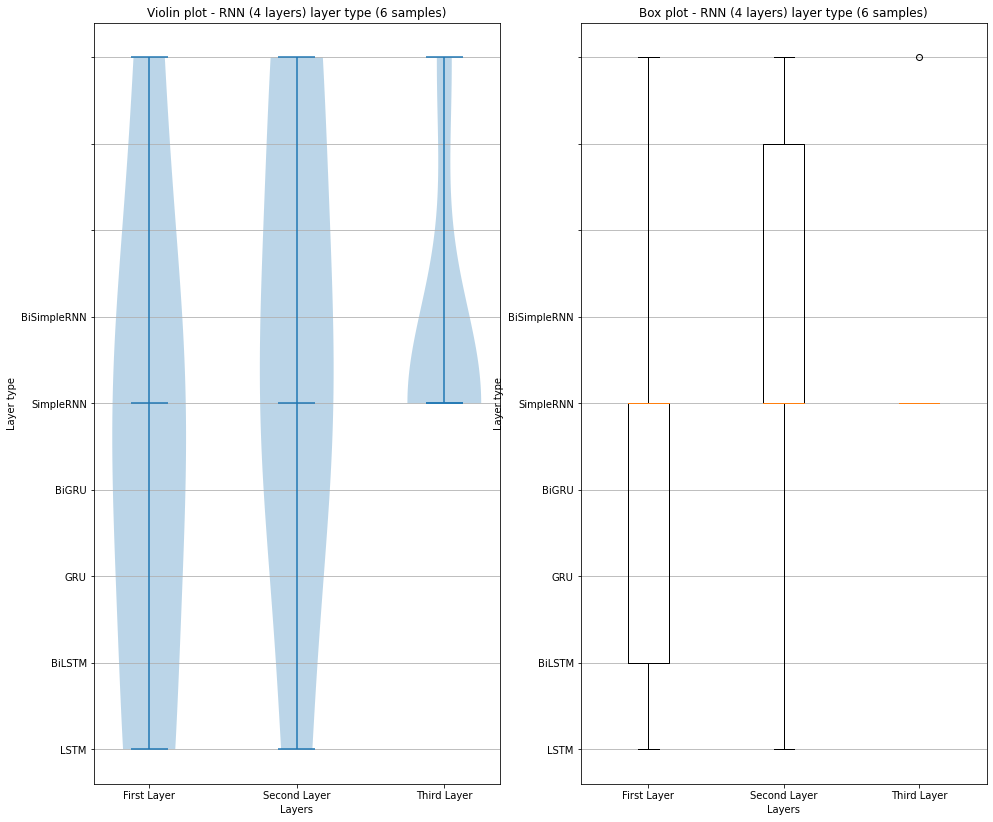

In [8]:
# Plot
import math
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
samples = len(layer_types[0])
labels = ["First Layer", "Second Layer", "Third Layer"]
all_data = layer_types
layer_type_labels = ['LSTM', 'LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) layer type ({} samples)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) layer type ({} samples)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('Layers')
    ax.set_ylabel('Layer type')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels, yticklabels=layer_type_labels)
plt.show()

In [9]:
# df_models
first_iterations = 400  # For the first EA iterations
# df_models2 = df.loc[df["experiment"] == current_experiment].head(first_iterations)  # For 1 experiment
# df_models2 = df[df['experiment'].isin(experiment_directories[4:7])]  # PM10 For many experiments
# df_models2 = df[df['experiment'].isin(experiment_directories[0:4])]  # O3
df_models2 = df[df['experiment'].isin(experiment_directories)]  # All

# df_models2 = df[df['experiment'].isin(experiment_directories[0:4])]  # For many experiments
a.append("holdoutSmapeAccuracy")
df_models3 = df_models2[a]

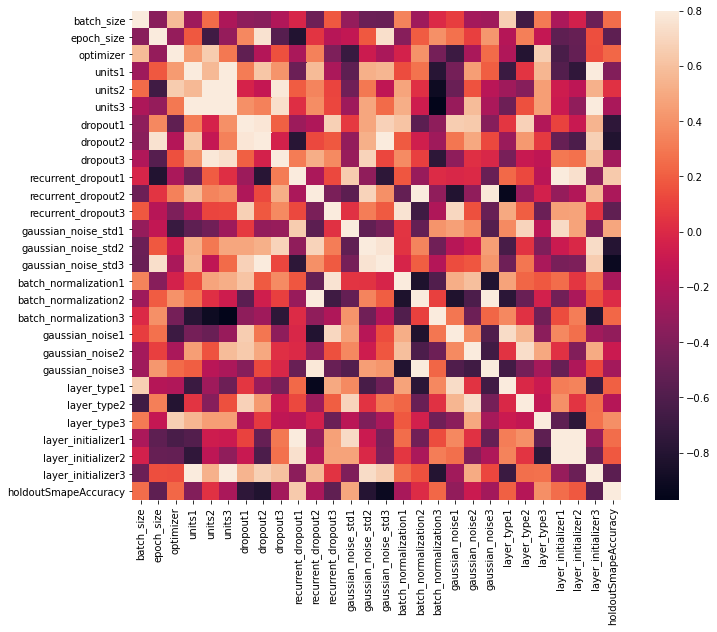

In [10]:
#correlation matrix
import seaborn as sns
df_models3 = df_models3
corrmat = df_models3.corr(method="pearson")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

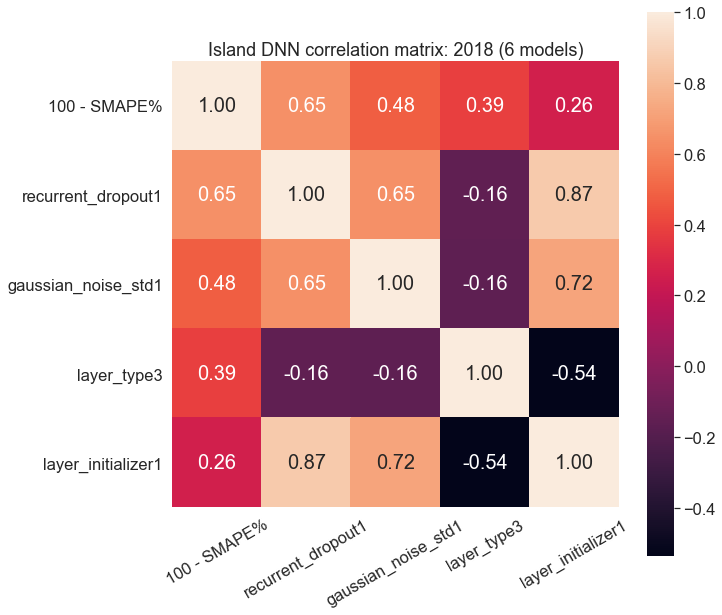

In [11]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
cm = np.corrcoef(df_models3[cols].values.T)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
col_labels = cols.values
col_labels[0] = "100 - SMAPE%"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
ax.set_title("Island DNN correlation matrix: 2018 ({} models)".format(df_models3.shape[0]))
hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=col_labels)
hm.set_xticklabels(labels=col_labels, rotation=30)
plt.show()
fig.savefig("pm10correlationMatrixTop.svg")

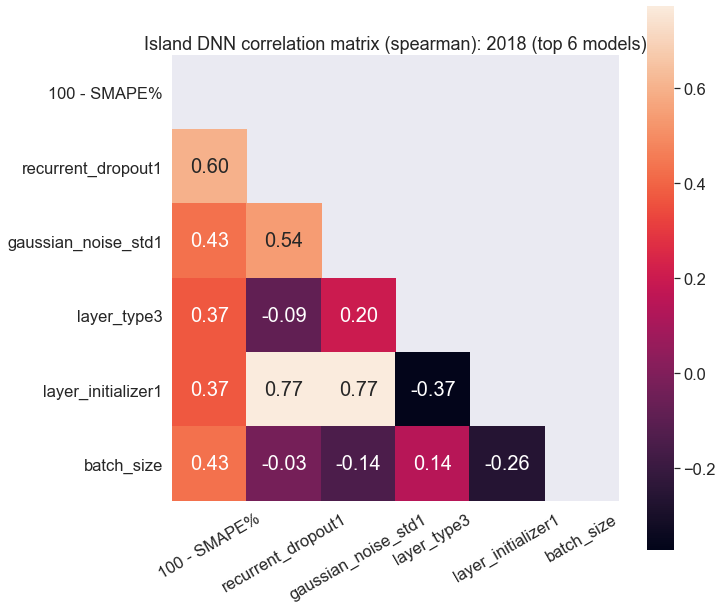

In [12]:
#saleprice correlation matrix

k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
# cm = np.corrcoef(df_models3[cols].values.T)
# cm = df_models3[cols].corr(method='pearson')
# cm = df_models3[cols].corr(method='kendall')
cor_method = "spearman"  # pearson: standard, kendall: tau, spearman: ranked
cm = df_models3[cols].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
col_labels = cols.values
col_labels[0] = "100 - SMAPE%"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
ax.set_title("Island DNN correlation matrix ({}): 2018 (top {} models)".format(cor_method, df_models3.shape[0]))
hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=col_labels, mask=mask)
sns.set(style="whitegrid")
hm.set_xticklabels(labels=col_labels, rotation=30)
plt.show()
fig.savefig("correlationMatrixRankedTop.svg")

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of ticklabels (4).

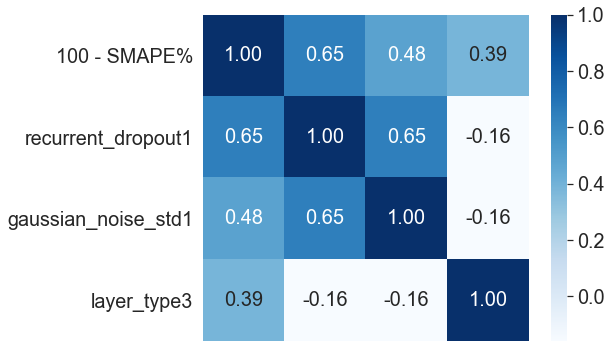

In [13]:
## saleprice correlation matrix
k = 4 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
cm = np.corrcoef(df_models3[cols].values.T)
sns.set(font_scale=1.8)
figure_size = (8, 6)
fig, ax = plt.subplots(figsize=figure_size)
col_labels = cols.values
col_labels[0] = "100 - SMAPE%"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
# ax.set_title("DNN (4 layers) correlation matrix: PM10 2018 ({} models)".format(df_models3.shape[0]))
# hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=col_labels)
hm = sns.heatmap(cm, ax=ax, cmap="Blues", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=[])
hm.set_xticklabels(labels=col_labels, rotation=25)
# hm.set_yticklabels(labels=col_labels, rotation=45)
ax.set_title('Correlations: Island DNN (top {} models)'.format(df_models3.shape[0]))
plt.show()
fig.savefig("dnnCorrelationMatrixTop.svg")

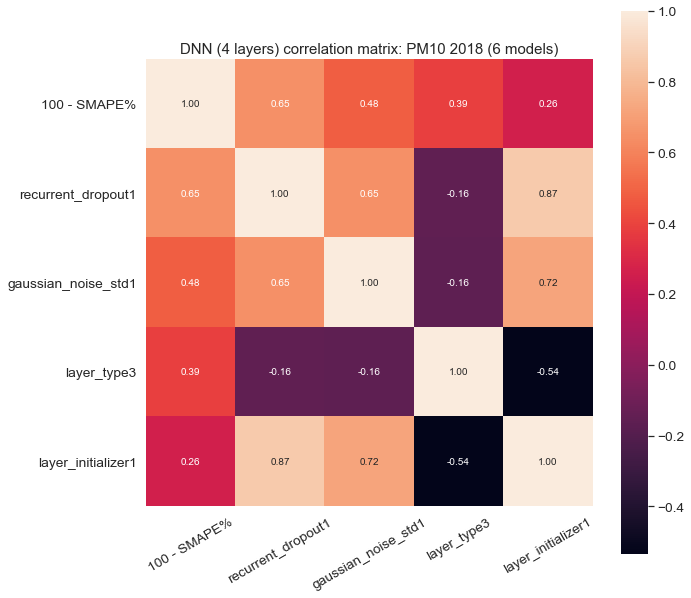

In [14]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
cm = np.corrcoef(df_models3[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10,10))
col_labels = cols.values
col_labels[0] = "100 - SMAPE%"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
ax.set_title("DNN (4 layers) correlation matrix: PM10 2018 ({} models)".format(df_models3.shape[0]))
hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=col_labels, xticklabels=col_labels)
hm.set_xticklabels(labels=col_labels, rotation=30)
plt.show()
fig.savefig("pm10correlationMatrixTop.svg")

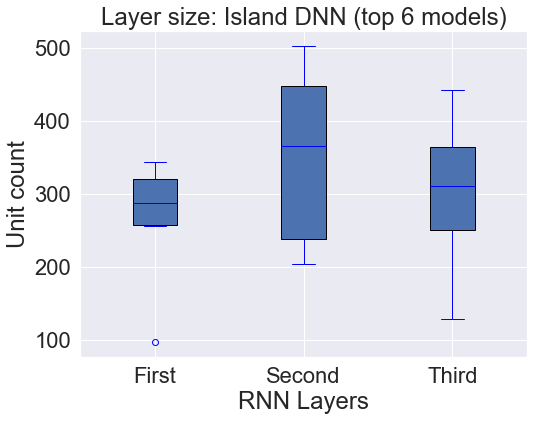

In [15]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

# ax.boxplot(all_data)
# ax.boxplot(df_models3["units1"])
# ax.boxplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]])
# ax.violinplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]], showmeans=False, showmedians=False)

c = "blue"

# ax.boxplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]], showfliers=True)

ax.boxplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]], showfliers=True, notch=False, patch_artist=True,
#             boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

# axes.scatter(all_data)
ax.set_title('Layer size: Island DNN (top {} models)'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Unit count')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("layerSizeBoxplotTop.svg")

In [16]:
df_models3.columns

Index(['batch_size', 'epoch_size', 'optimizer', 'units1', 'units2', 'units3',
       'dropout1', 'dropout2', 'dropout3', 'recurrent_dropout1',
       'recurrent_dropout2', 'recurrent_dropout3', 'gaussian_noise_std1',
       'gaussian_noise_std2', 'gaussian_noise_std3', 'batch_normalization1',
       'batch_normalization2', 'batch_normalization3', 'gaussian_noise1',
       'gaussian_noise2', 'gaussian_noise3', 'layer_type1', 'layer_type2',
       'layer_type3', 'layer_initializer1', 'layer_initializer2',
       'layer_initializer3', 'holdoutSmapeAccuracy'],
      dtype='object')

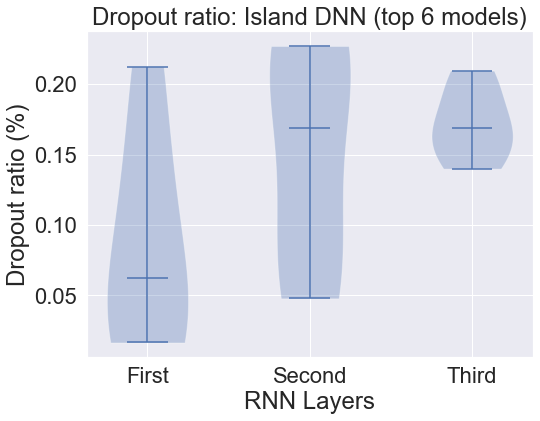

In [17]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
# ax.boxplot([df_models3["dropout1"], df_models3["dropout2"], df_models3["dropout3"]], showfliers=True, notch=False, patch_artist=True,
#             capprops=dict(color=c),
#             whiskerprops=dict(color=c),
#             flierprops=dict(color=c, markeredgecolor=c),
#             medianprops=dict(color=c))

ax.violinplot([df_models3["dropout1"], df_models3["dropout2"], df_models3["dropout3"]], showmeans=False, showmedians=True)

ax.set_title('Dropout ratio: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Dropout ratio (%)')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("dropoutRatioViolinplotTop.svg")

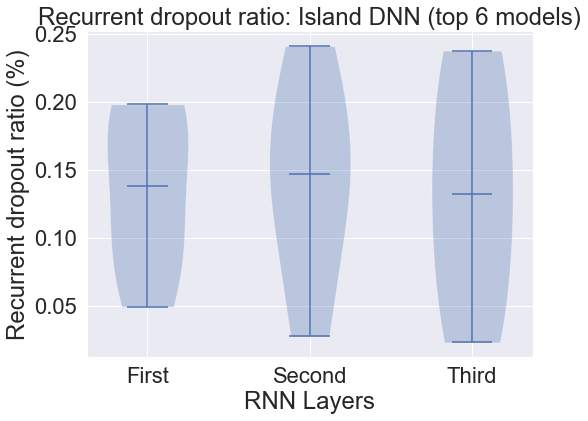

In [18]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
# ax.boxplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showfliers=True, notch=False, patch_artist=True,
#             capprops=dict(color=c),
#             whiskerprops=dict(color=c),
#             flierprops=dict(color=c, markeredgecolor=c),
#             medianprops=dict(color=c))

ax.violinplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showmeans=False, showmedians=True)

ax.set_title('Recurrent dropout ratio: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Recurrent dropout ratio (%)')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("recurrentDropoutRatioViolinplotTop.svg")

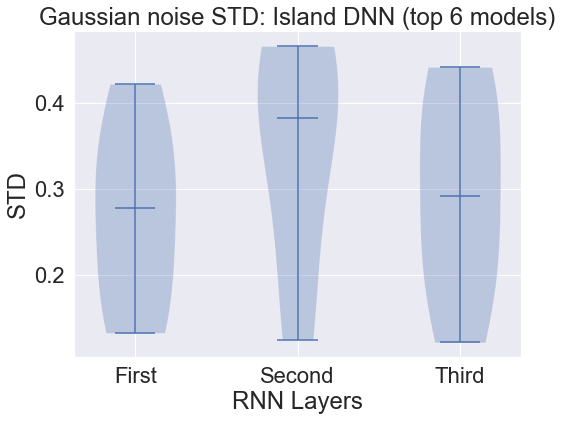

In [19]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
# ax.boxplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showfliers=True, notch=False, patch_artist=True,
#             capprops=dict(color=c),
#             whiskerprops=dict(color=c),
#             flierprops=dict(color=c, markeredgecolor=c),
#             medianprops=dict(color=c))

ax.violinplot([df_models3["gaussian_noise_std1"], df_models3["gaussian_noise_std2"], df_models3["gaussian_noise_std3"]], showmeans=False, showmedians=True)

ax.set_title('Gaussian noise STD: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('STD')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("gaussianNoiseStdViolinplotTop.svg")

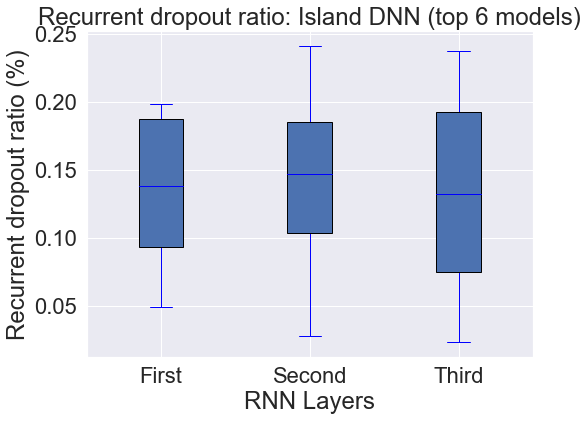

In [20]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
ax.boxplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showfliers=True, notch=False, patch_artist=True,
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

ax.set_title('Recurrent dropout ratio: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Recurrent dropout ratio (%)')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

# fig.savefig("layerSizeBoxplot.svg")

KeyError: 0

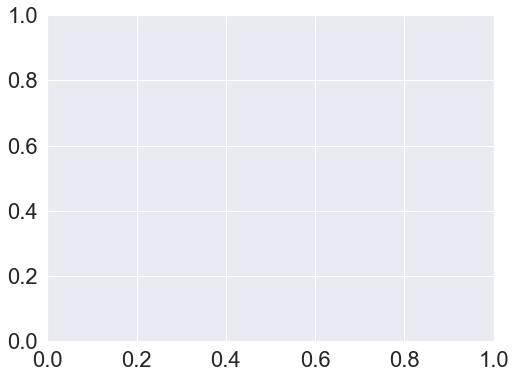

In [21]:
sns.set(style="whitegrid")
sns.set(font_scale=2.0)
figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
layer_type_labels = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']

layer_type_counts = df_models3["layer_type3"].round().astype(int).value_counts()
bp_layers = sns.barplot(x=[0, 1, 2, 3, 4, 5], y=layer_type_counts)
ax.set_title('Layer types: DNNs with 3 x RNN layers (top {} models)'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
# ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_ylabel('Count')
ax.set_xlabel('Layer type')
plt.setp(ax, xticklabels=layer_type_labels)
bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
plt.show()
fig.savefig("layerTypeBarplotTop.svg")

In [ ]:

# x(['batch_size', 'epoch_size', 'optimizer', 'units1', 'units2', 'units3',
#        'dropout1', 'dropout2', 'dropout3', 'recurrent_dropout1',
#        'recurrent_dropout2', 'recurrent_dropout3', 'gaussian_noise_std1',
#        'gaussian_noise_std2', 'gaussian_noise_std3', 'batch_normalization1',
#        'batch_normalization2', 'batch_normalization3', 'gaussian_noise1',
#        'gaussian_noise2', 'gaussian_noise3', 'layer_type1', 'layer_type2',
#        'layer_type3', 'layer_initializer1', 'layer_initializer2',
#        'layer_initializer3', 'holdoutSmapeAccuracy'],


sns.set(style="whitegrid")
sns.set(font_scale=2.0)
figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
# layer_type_labels = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']
#     optimizers = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam',
#                   'nadam']  # Avoid loss NaNs, by removing rmsprop, sgd, adamax. TODO: ftrl: needs lr param (for future)
layer_type_labels = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam', 'nadam']

layer_type_counts = df_models3["optimizer"].round().astype(int).value_counts()
bp_layers = sns.barplot(x=[0, 1, 2, 3, 4], y=layer_type_counts)
ax.set_title('Optimizer: DNNs with 3 x RNN layers (top {} models)'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
# ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_ylabel('Count')
ax.set_xlabel('Optimizer')
plt.setp(ax, xticklabels=layer_type_labels)
bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
plt.show()
fig.savefig("optimizerBarplotTop.svg")

In [ ]:
layer_type_counts.unique

In [ ]:

# x(['batch_size', 'epoch_size', 'optimizer', 'units1', 'units2', 'units3',
#        'dropout1', 'dropout2', 'dropout3', 'recurrent_dropout1',
#        'recurrent_dropout2', 'recurrent_dropout3', 'gaussian_noise_std1',
#        'gaussian_noise_std2', 'gaussian_noise_std3', 'batch_normalization1',
#        'batch_normalization2', 'batch_normalization3', 'gaussian_noise1',
#        'gaussian_noise2', 'gaussian_noise3', 'layer_type1', 'layer_type2',
#        'layer_type3', 'layer_initializer1', 'layer_initializer2',
#        'layer_initializer3', 'holdoutSmapeAccuracy'],


sns.set(style="whitegrid")
sns.set(font_scale=2.0)
figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
# layer_type_labels = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']
#     optimizers = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam',
#                   'nadam']  # Avoid loss NaNs, by removing rmsprop, sgd, adamax. TODO: ftrl: needs lr param (for future)
layer_type_labels = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam', 'nadam', 'nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam', 'nadam']

layer_type_counts = df_models3["layer_initializer1"].round().astype(int).value_counts()
bp_layers = sns.barplot(x=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y=layer_type_counts)
ax.set_title('Optimizer: DNNs with 3 x RNN layers (all {} models)'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
# ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_ylabel('Count')
ax.set_xlabel('Optimizer')
plt.setp(ax, xticklabels=layer_type_labels)
bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
plt.show()
# fig.savefig("optimizerBarplot.svg")

# BETN073

In [ ]:
import os
import pandas as pd
import glob
import re
import numpy as np

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = [
#     "18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_background_rural_stations",
    "18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_1_station_calendar"
#     "18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar", 
#                           "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar", 
#                           "18Islands20AgentsO3_1994-2018_16_stations_calendar", 
#                           "18Islands5AgentsO3_1994-2018_16_stations_calendar",
#                           "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
#                           "18Islands20AgentsPM10_1994-2018_16_stations_calendar",
#                           "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
#         df["cvSmapeMean"] = 100 * df["cvSmapeMean"]
#         df["holdoutSmape"] = 100 * df["holdoutSmape"]  
#         df["holdoutMape"] = 100 * df["holdoutMape"]        
#         df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
#         df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]
#         print("df.shape", df.shape)
        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()        

In [ ]:
df.tail(50)

In [ ]:
df["holdoutMse"].min()

In [ ]:
df["holdoutSmape"].min()

In [ ]:
df["holdoutMape"].min()

In [ ]:
df["holdoutIoa"].max()

In [ ]:
df["holdoutSmape"].max()

In [ ]:
df["cvMseMean"].min()